# Wavelets for Human Activity Recognition (HAR)

Source - http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import sys
sys.path.append(
    "../../13-ts-feature-extraction/"
)
import warnings
warnings.filterwarnings("ignore")

import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter
from tqdm.autonotebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from src.utils import *

In [2]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

activities_labels = [
    'walking',
    'walking upstairs',
    'walking downstairs',
    'sitting',
    'standing',
    'laying'
]

INPUT_FOLDER_TRAIN = '../data/raw/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = '../data/raw/UCI_HAR/test/InertialSignals/'

LABELFILE_TRAIN = '../data/raw/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = '../data/raw/UCI_HAR/test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [3]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

In [4]:
waveletname = 'rbio3.1'
X_train, Y_train = get_uci_har_features(train_signals, train_labels, waveletname)
X_test, Y_test = get_uci_har_features(test_signals, test_labels, waveletname)

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

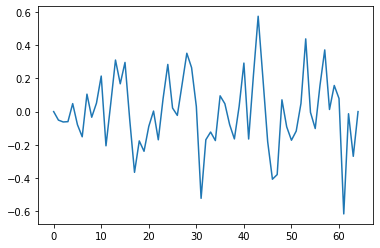

In [5]:
plt.plot(pywt.wavedec(train_signals[0, :, 0], waveletname)[5])

In [6]:
X_train.shape, X_test.shape

((7352, 648), (2947, 648))

In [7]:
648/9

72.0

In [8]:
72.0/6

12.0

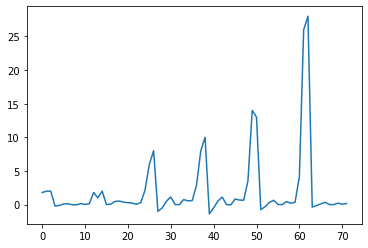

In [9]:
plt.plot(X_train[0][:72]);

<AxesSubplot: >

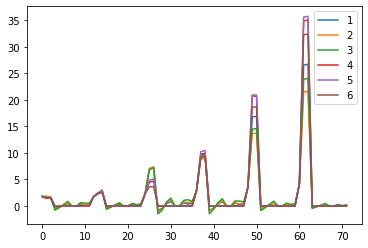

In [10]:
pd.DataFrame(X_train).groupby(pd.Series(Y_train)).mean().iloc[:, :72].T.plot()

In [11]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {:.2f}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {:.2f}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred, target_names=activities_labels))

Accuracy on training set is : 1.00
Accuracy on test set is : 0.92
                    precision    recall  f1-score   support

           walking       0.91      0.95      0.93       496
  walking upstairs       0.89      0.93      0.91       471
walking downstairs       0.91      0.82      0.86       420
           sitting       0.92      0.88      0.90       491
          standing       0.90      0.93      0.91       532
            laying       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



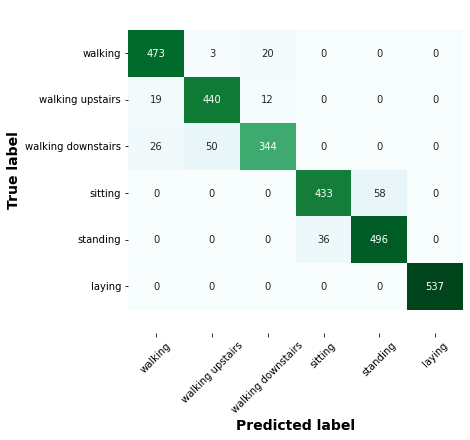

In [12]:
plot_confusion(Y_test, Y_test_pred, activities_description.values())